<a href="https://colab.research.google.com/github/AnaGutson/Organizacion-de-datos/blob/main/Ensamble_de_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **General**

Todo está escrito con un ejemplo, para mostrar una forma de realizar cada cosa.

## Carga de dataset a la notebook


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ds_titanic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic.csv')
ds_trabajo = ds_titanic.copy()

## Código para realizar predicción genérica


In [ ]:
#Se eliminan variables que no sirven
columnas_eliminar=['PassengerId','Name',"Ticket"]
ds_trabajo.drop(columnas_eliminar, axis='columns', inplace=True)  #Elimina columna sobre el mismo dataframe

#Se eliminan datos faltantes
columnas_eliminar_NANs=['Cabin']
ds_trabajo.drop(columnas_eliminar_NANs, axis='columns', inplace=True)
ds_trabajo=ds_trabajo.dropna()

#Se obtienen los sets de entrenamiento y test
ds_trabajo_x = ds_trabajo.drop(['Survived'], axis='columns', inplace=False)
ds_trabajo_y = ds_trabajo['Survived'].copy()
x_train, x_test, y_train, y_test = train_test_split(	ds_trabajo_x, 
                                                      ds_trabajo_y, 
	                                   		              test_size = 0.3,    		#30% al conjunto de test
	                                                  	random_state = 13, 	    #para poder reproducir el experimento
                  	                                	stratify=ds_trabajo_y)  #estratificado para mantener proporcion

#Se calcula el porcentaje de datos, tanto de entrenamiento como de test
pd.Series(y_train).value_counts(normalize=True)[1]*100
pd.Series(y_test).value_counts(normalize=True)[1]*100

#Se escalan los datos de entrenamiento con MinMaxScaler()
scaler = MinMaxScaler() 
scaler.fit(pd.DataFrame(x_train['Age']))
x_train['Age']=scaler.transform(x_train['Age'].to_frame())
x_test['Age']=scaler.transform(x_test['Age'].to_frame())

#Se entrena el modelo
model = #modelo
model.fit(X = x_train, y = y_train)

#Se hace la prediccion
y_pred = model.predict(x_test)

#Se crea un dataset nuevo para visualizarlo
ds_resultados = pd.DataFrame(zip(y_test, y_pred), columns=['test', 'pred'])
ds_resultados.head()

#Se puede visualizar en una matriz de confusion
tabla=confusion_matrix(ds_resultados['test'], ds_resultados['pred'])
grf=sns.heatmap(tabla,annot=True)
plt.show()

#Se pueden calcular las metricas
accuracy=accuracy_score(ds_resultados['test'], ds_resultados['pred'], normalize=True)
recall=recall_score(ds_resultados['test'], ds_resultados['pred'])
f1=f1_score(ds_resultados['test'], ds_resultados['pred'])

## **Búsqueda de hiperparámetros**

Se busca construir el "mejor" clasificador eligiendo los hiperparametros más adecuados mediante validación cruzada.

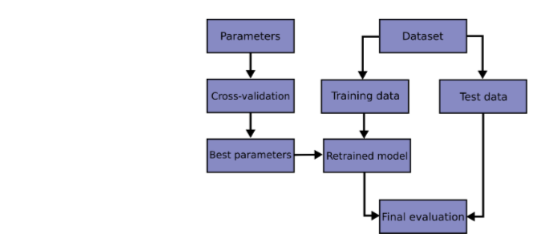

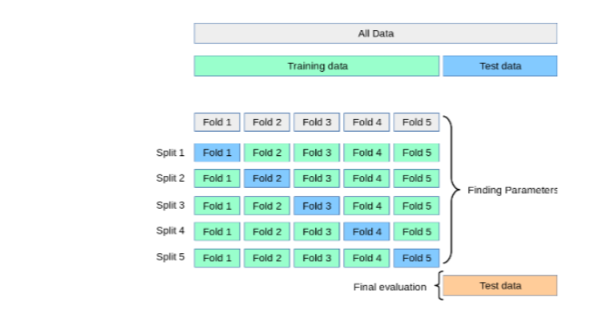

Para encontrar la mejor combinación de hiperparámetros, se explora un espacio de búsqueda, usando k-fold CV para medir el desempeño de cada combinación. Al terminar, se elige la combinación con mejor desempeño y se entrena un único modelo usando todos los datos de train.

Las exploraciones pueden ser:
- **Random Search**: explorar opciones y combinaciones al azar.
- **Grid Search**: se plantean y exploran todas las combinaciones.

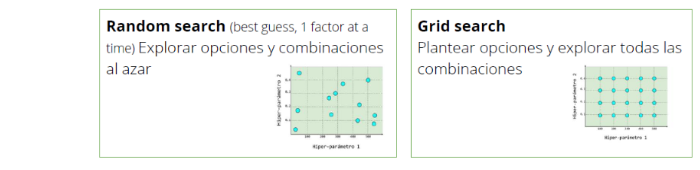

### Ejemplos


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

#### Random Search con árbol

In [ ]:
#Cantidad de combinaciones que se quiere probar
n=20 

#Conjunto de parámetros que se quiere usar
params_grid = {'criterion': ['gini','entropy'],
               #'min_samples_leaf': list(range(1, 10)),
		           #'min_samples_split': list(range(2, 20)),
	             'ccp_alpha': np.linspace(0, 0.05, n), 
               'max_depth': list(range(1, 10))}

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits = folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n) 

#Busco los hiperparametros que optimizan F1 Score
randomcv.fit(x_train,y_train)

#Mejores hiperparametros del árbol
randomcv.best_params_

#Mejor métrica
randomcv.best_score_

#Todas las métricas obtenidas
randomcv.cv_results_['mean_test_score']

#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_
sorted(zip(feat_imps,ds_trabajo_x.columns.values))

#Me quedo con los mejores hiperparametros: opcion 1
tree_cv_best=gs_fit.best_estimator_
y_pred_tree_cv_best = tree_cv_best.predict(x_test)

#Me quedo con los mejores hiperparametros: opcion 2
params_elegidos=gs_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_roc_auc'])]
base_tree = DecisionTreeClassifier(	criterion = params_elegidos['criterion'], 
              		 		ccp_alpha =   params_elegidos['ccp_alpha'],
               				max_depth =   params_elegidos['max_depth']	)
model = base_tree .fit(X = x_train, y = y_train)
y_pred_cv_best = model.predict(x_test)

#### Grid Search con árbol

In [ ]:
#Se crea un clasificador vacío
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10],
              "max_features":["sqrt", "log2"],
              "min_samples_split" : [2, 4, 10],
              "n_estimators": [10,20, 50] }

#Se prueba entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

#Se entrena un modelo con la mejor combinacion de hiperparametros
gs_fit = gs.fit(X = x_train, y = y_train)
params_elegidos = gs_fit.cv_results_['params'][np.argmax(gs_fit.cv_results_['mean_test_roc_auc'])]
rfc = RandomForestClassifier(	criterion= params_elegidos['criterion'], 
			min_samples_leaf= params_elegidos['min_samples_leaf'], 
			min_samples_split= params_elegidos['min_samples_split'], 
			n_estimators=params_elegidos['n_estimators'], 
			max_features=params_elegidos["max_features"],
			random_state=2, n_jobs=-1)
model_rfc= rfc.fit(X = x_train, y = y_train)
y_pred_model_rfc = model_rfc.predict(x_test)

# **Ensamble de modelos**

La combinación de clasificadores permite generar clasificadores más precisos a cambio de menor comprensión de los mismos.

**Ventajas.**
- Generalmente logran **mejores predicciones** que los modelos vistos hasta ahora.
- Buen trade-off sesgo varianza.

**Desventajas.**
- Se pierde interpretabilidad.
- Tienen una **complejidad computacional mayor**.

**Error de Bias/Sesgo**

error de bias $=$ error esperado $-$ valor real.

Error de “suposiciones erróneas” en el algoritmo de aprendizaje.

$\rightarrow$ Si se tiene un modelo con un bias muy alto, quiere decir que el modelo es simple y no se ha ajustado a los datos de entrenamiento (suele ser underfitting), por lo que se produce un error alto es todas las muestras: entrenamiento, validación y test.



**Varianza**

Es cuánto varía la predicción según los datos que se utilicen en el entrenamiento.

$\rightarrow$ Si se tiene un modelo con **varianza baja**, significa que cambiar los datos de entrenamiento produce cambios pequeños en la estimación.
$\rightarrow$ Si se tiene un modelo con **varianza alta**, significa que pequeños datos en el dataset conllevan a grandes cambios en el output (suele ser overfitting).

**Votación**
Para una nueva instancia, se clasifican todo los modelos y se devuelve la clase más elegida.
- Reduce la varianza de la clasificación (por ejemplo, Random Forest).
- Si los modelos individuales devuelven probabilidades, se puede hacer una **votación ponderada**. Sino, se hace **votación sencilla**.


**Técnicas para construir modelos ensamblados.**

**Ensambles homogéneos**: combinan el mismo tipo de clasificador.

$\rightarrow$ Manipulan el conjunto de entrenamiento.
- Bagging.
- Boosting.

**Ensambles híbridos**: combinan clasificadores de distinto tipo.
- Voting. $\quad$ (es el más básico)
- Stacking.
- Cascading.


## **Ensambles homogéneos**

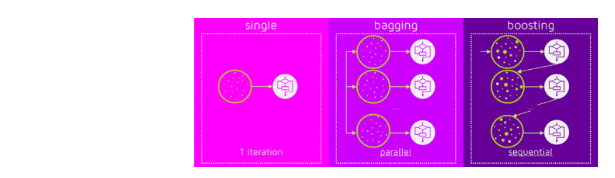

### **Bagging**

Es la **más sencilla** de todas.

Poco práctico: los datos son caros.

Es importante que los modelos estén poco correlacionados.

A su vez, Bagging utiliza otra técnica conocida como **bootstrap** (muestras aleatorias con reemplazo) para entrenar distintos modelos y luego combinarlos.


> Pasos:
- Se divide el conjunto de entrenamiento en distintos subconjuntos, obteniendo como resultado diferentes muestras aleatorias.
  - Las muestras son uniformes (misma cantidad de individuos).
  - Son muestras con reemplazo (los individuos pueden repetirse en el mismo conjunto de datos).
- Se entrena un modelo con cada subconjunto (**en paralelo**).
- Se construye un único modelo predictivo a partir de los anteriores.


**Características**
- Disminuye la varianza en el modelo final.
- Muy efectivo en conjunto de datos con varianza alta.
- Puede reducir el overfitting.
- Puede reducir el ruido de los outliers (porque no aparecen en todos los datasets).
- Puede mejorar levemente con el voto ponderado.


**Problemas al usarlo con árboles**
- Si pocos atributos son predictores fuertes, todos los árboles se van a parecer entre sí. \\
$\rightarrow$ Tiene más sentido usarlo cuando todos los atributos tienen el mismo peso en la predicción final.
- Esos atributos terminarán cerca de la raíz, para todos los conjuntos generados con bootstrap.


Hay una leve diferencia entre Random Forest y la técnica tradicional de Bagging: en Random Forest se suelen reducir las columnas de cada partición, mientras que en Bagging no se suele hacer esto.

### **Boosting**

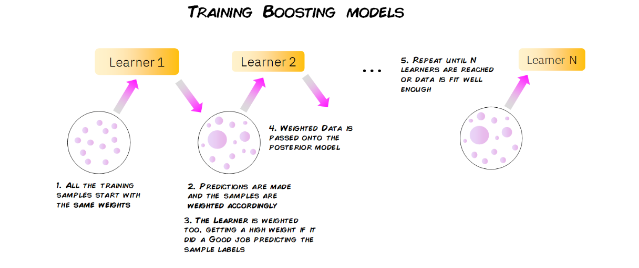

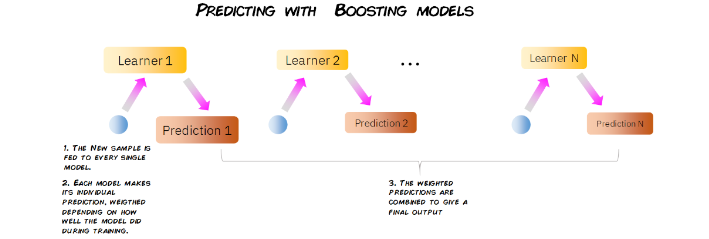

Es un entrenamiento en **forma secuencial**.


> Pasos:
- Se comienza con un modelo (simple) entrenado sobre todos los datos: $h_0$.
- En cada iteración $i$, se entrena $h_i$ dando mayor importancia a los datos mal clasificados por las iteraciones anteriores.
- Se termina al conseguir cierto cubrimiento, o luego de un número de iteraciones. 
- Se clasifican nuevas instancias usando una votación ponderada de todos los modelos construídos. 


Modelos exitosos que utilizan esta técnica:
- AdaBoost.
- Gradient Boosting.
- XGBoost: eXtreme Gradient Boosting.


**XGBoost vs. Gradient Boosting**:

La velocidad de entrenamiento de XGBoost es mucho menor gracias a su implementación y a estar mejor orientado al uso eficiente del hardware (GPU).
El accuracy (o la métrica adecuada) también es mejor debido a que XGBoost maneja mejor el overfitting mediante regularizaciones (esto lo veremos más adelante).


En resumen, boosting:
- Necesita de pesos, esto implica que:
  - Se debe adaptar el algoritmo de aprendizaje.
  - Se deben tomar muestras con reemplazo según pesos.
- Puede sobreajustar.


#### **AdaBoost**

La **implementación más común** es **con árboles**.

**Contras**

- El entrenamiento **no puede hacerse en paralelo** (como los árboles de Random Forest) y es por lo tanto **poco escalable**.

A diferencia de Random Forest, donde se tienen $N$ árboles completos (de distinta profundidad pero completos), en AdaBoost se tiene un bosque de tocones (stumps).


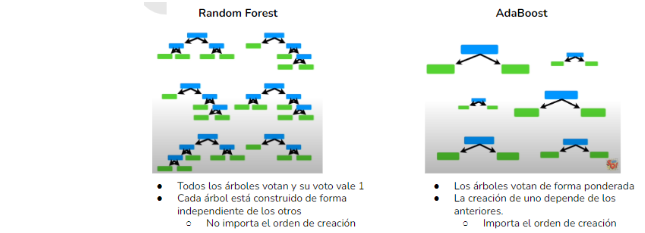

**Stump**: un nodo raíz y dos hojas.

Cada stump individual no es un buen clasificador.


##### **Ejemplo**

- Primero se establece el mismo peso para todas las variables: $\frac{1}{\#ejemplos}$.


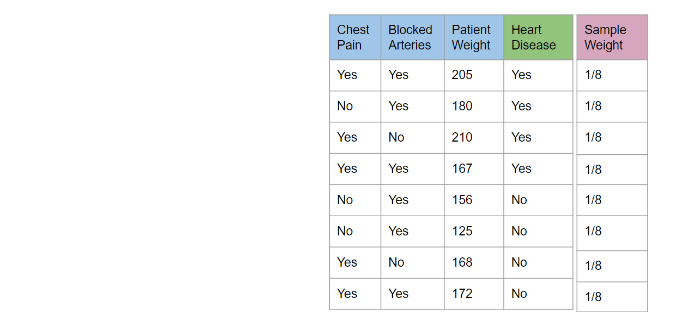

- Luego, se calcula el stump de cada variable (los umbrales se calculan como en $C4.5$):


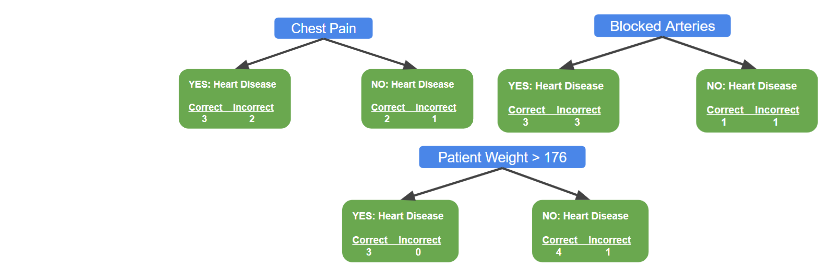

- Se calcula el índice de Gini para los stumps. El primer stump del bosque será aquel cuyo coeficiente sea el más bajo. Se debe calcular el peso relativo del tocón en el clasificador final: **amount of say** $= \frac12 \ln \frac{(1- \textrm{Total Error})}{\textrm{Total Error}}$. Para calcularla se necesita el **Error Total** del tocón: $\frac{(\#\textrm{mal clasificados})}{(\#total)}$.


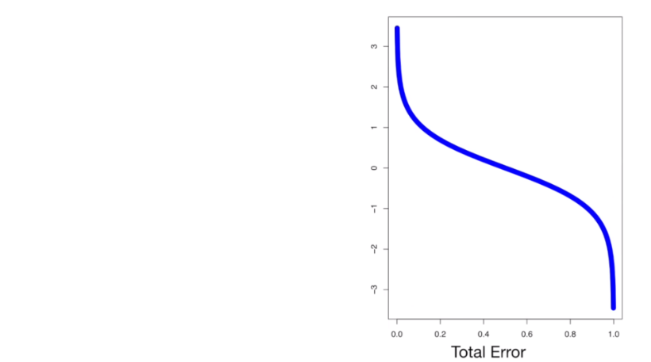

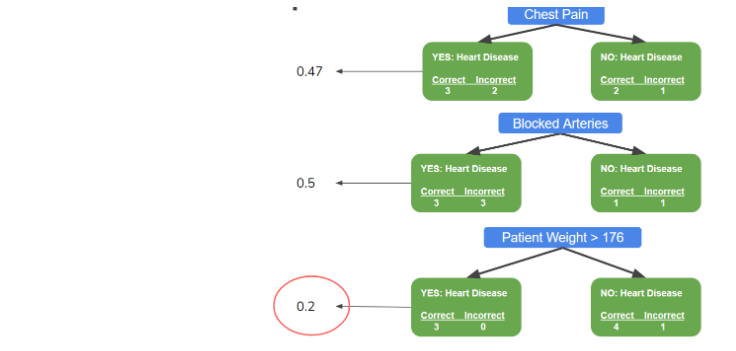

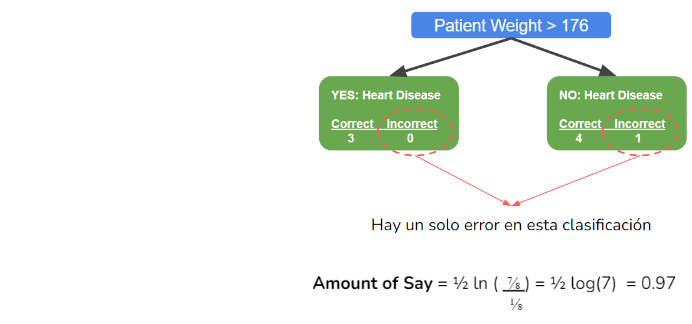

- Se modifica el peso del ejemplo mal clasificado: 
$$\textrm{new sample weight} = (\textrm{sample weight}) . e^{\textrm{amount of say}}$$
y se modifica el peso del resto: 
$$\textrm{new sample weight} = (\textrm{sample weight}) . e^{- \textrm{amount of say}}.$$ Luego, dichos valores se normalizan (se divide cada peso por la suma total).

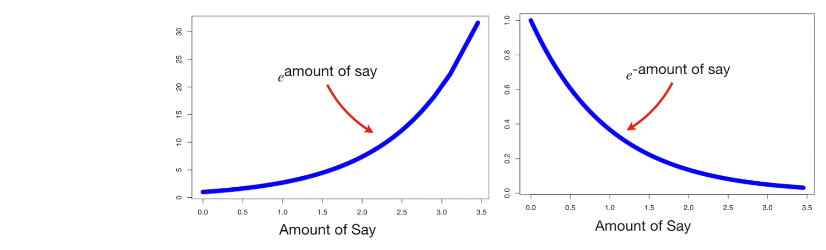

> - Ejemplo mal clasificado: $0,33$.
- Resto: $0,05$.

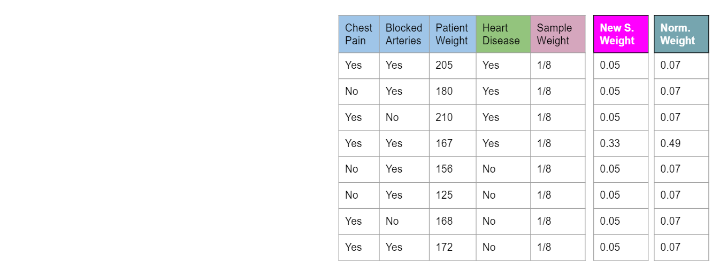

- Se crea el siguiente tocón con estos nuevos pesos. Hay dos posibilidades:
  - Utilizar la impureza de Gini ponderada para saber qué tocón clasifica mejor el ejemplo con más peso.
  - Generar un nuevo dataset teniendo en cuenta los pesos:
    - Se arma una distribución de valores (sumando los pesos).
    - Se elige un número al azar entre $0$ y $1$.
    - Se verifica en qué fila cae y se agrega ese ejemplo al dataset.
    - Se vuelve a hacer todo el procedimiento nuevamente a partir de este nuevo dataset.

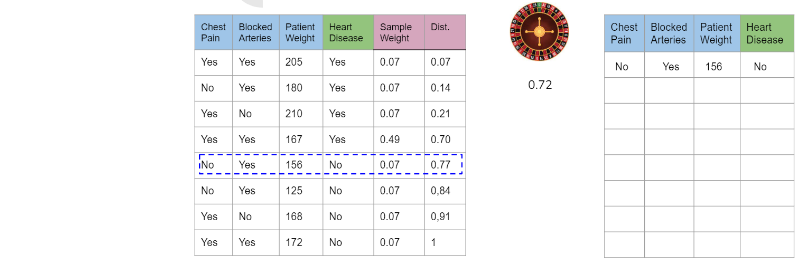

- Ya se tiene el bosque de tocones.

Para predecir:
- Se predice con cada arbol. Luego, se suma el amount of say de cada arbol por cada respuesta. Es decir, se calcula el amount of say total de la opción “true” y luego el amount of say de la opción “false”. Se elige la opción cuyo amount of say es mayor.


##### **Resumen**

- AdaBoost combina un monton de weak learners (estimadores pobres) para hacer clasificaciones. Estos weak learners, son generalmente stumps (tocones).
- Algunos tocones tienen más peso que otros en la votación final, tienen más que decir (amount of say)
- Cada uno de estos tocones está construido teniendo en cuenta los errores del tocón anterior.
  - Usando una función de impureza de Gini ponderada, para cada ejemplo
  - O regenerando los datos.


##### **Código**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

#Separo un set de Evaluacion
x_train, x_test, y_train, y_test = train_test_split(dataset[features].values,
                                                    dataset['Target'].values,
                                                    test_size=0.2,                      #20% al conjunto de test
                                                    random_state=13,                    #para poder reproducir el experimento
                                                    stratify=dataset['Target'].values)  #estratificado para mantener proporcion
ab_model = AdaBoostClassifier(n_estimators=10, random_state=0)
ab_model.fit(x_train, y_train)

#Se grafica el primer STUMP
dot_data = StringIO()
export_graphviz(ab_model.estimators_[0], out_file=dot_data, filled=True, rounded=True,
                special_characters=True,feature_names=features,class_names=['No','Yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
y_pred=ab_model.predict(x_test)

#### **Gradient Boost**

Se puede utilizar para problemas de regresión o de clasificación.

“Un pequeño paso en la dirección correcta”.


> **Pasos**
- Gradient Boost crea una cadena de árboles de profundidad fija. 
- Comienza con un solo valor, un nodo hoja. Y luego calcula árboles para calcular el error cometido por el anterior.
- Cada árbol está ponderado por un factor constante llamado **learning rate** o tasa de aprendizaje.
  - Los árboles están restringidos en su crecimiento


##### **Ejemplo**

- Se quiere predecir el peso de una persona. Lo primero que se hace es calcular el promedio de los pesos existentes: $71.2$ kg.

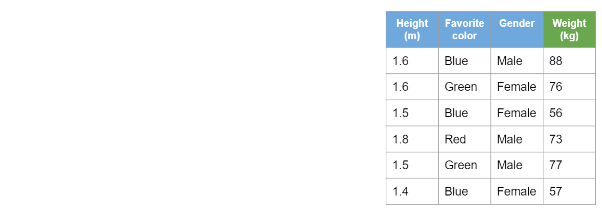

- Se calcula el error cometido por el estimador hasta ahora, es decir el **pseudo-residuo**.

Pseudo-Residuo $=$ Peso observado $-$ peso predicho.


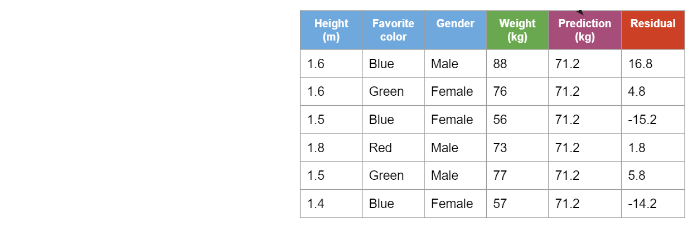

- Se construye un arbol para los residuos. Es este caso tendrá solo $4$ hojas, pero en casos reales suele tener entre $8$ y $32$ hojas.

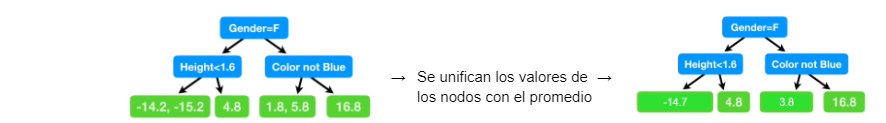

> Gradient Boost maneja el overfitting usando un parámetro llamado Learning Rate, para escalar la contribución de cada árbol. Este es un valor entre $0$ y $1$.

**Para predecir**


- Se elige un learning rate al azar. Por ejemplo $0.1$
Se hace $$\textrm{prediccion} = \textrm{peso_promedio_inicial} + \textrm{learning_rate } \times \textrm{ valor_que_diga_el_arbol}.$$
Ese va a ser el valor predicho. En este caso, $72.9$ kg.


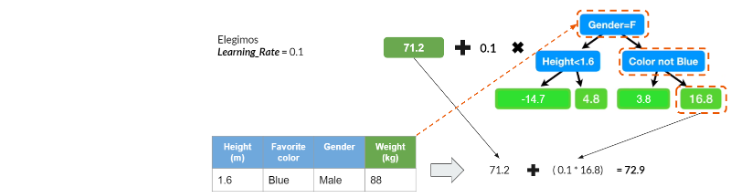

- Se calcula el residuo y se vuelve a generar un nuevo árbol.


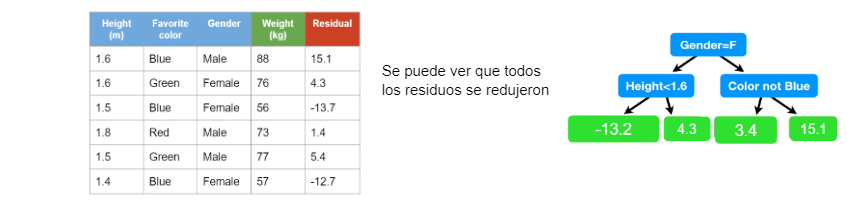

- Entonces, para predecir, ahora se hace
$$\textrm{prediccion} = \textrm{peso_promedio_inicial} + \textrm{learning_rate } \times \textrm{ valor_arbol_1} + \textrm{learning_rate } \times \textrm{ valor_arbol_2}.$$

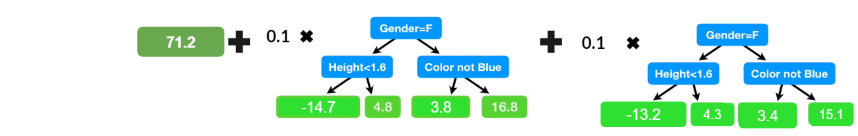

- Se repite el proceso hasta que los residuos no cambien significativamente o bien se alcance un número preestablecido de árboles seteados como parámetro.

##### **Código**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#Separo un set de Evaluacion
x_train, x_test, y_train, y_test = train_test_split(dataset[features].values,
                                                    dataset['Target'].values,
                                                    test_size=0.2,                        #20% al conjunto de test
                                                    random_state=13,                      #para poder reproducir el experimento
                                                    stratify = dataset['Target'].values)  #estratificado para mantener proporcion
gb_model = GradientBoostingClassifier(random_state=17)
gb_model.fit(x_train, y_train)

#Se grafica el primer árbol 
dot_data = StringIO()
export_graphviz(gb_model.estimators_[0][0], out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=features)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
y_pred=gb_model.predict(x_test)

#### **XGBoost**

Fue diseñado para Big Data, es decir para conjuntos de datos grandes y complejos.

Sin embargo acá se usará con un conjunto de datos simple (y para el caso de regresión).


##### **Ejemplo**

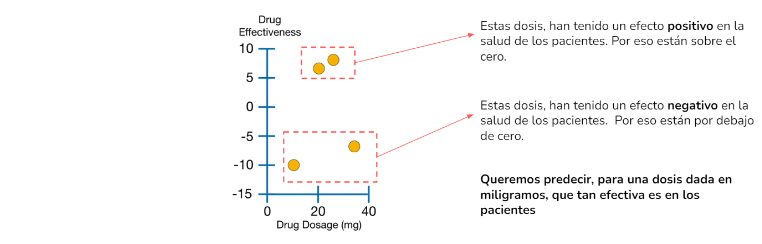

- Se hace una predicción inicial. Por defecto se toma $0.5$ (valor del eje $y$).
- Se calculan los residuos.


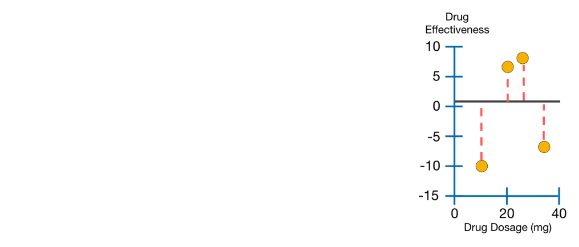

- Se construye un árbol para estos residuos. Primero se coloca un nodo hoja con todos los residuos.


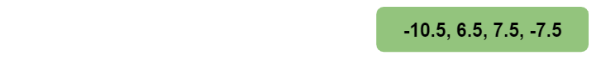

- Se calcula el **Similarity Score** para los residuos:
$$\textrm{Similarity Score} = \frac{\textrm{Suma de residuos}^2}{\textrm{Cantidad de residuos} + λ}, \quad \textrm{con λ un parámetro de regularizacion}$$
Por momento se toma $λ = 0$.
El Similarity Score para los residuos del nodo actual es $4$.

> **Regularización**
>
> Se introduce un error de sesgo en el estimador para que no se ajuste tan bien a los datos, por lo cual caerá el error por la varianza de forma mucho más abrupta en el conjunto de pruebas.
>
> Un claro ejemplo es Ridge Regression con respecto a Cuadrados mínimos.


- Para ver cuál será el siguiente nodo, se calcula la ganancia total de las siguientes opciones:
  - Opción 1: se toma como umbral la distancia intermedia entre las primeras $2$ observaciones.
  - Opción 2: se toma como umbral la distancia intermedia entre las segundas $2$ observaciones.
  - Opción 3: se toma como umbral la distancia intermedia entre las últimas $2$ observaciones.
- Se comienza con la primera opción. Se arma el árbol y se calcula el Similarity Score para cada hoja. La ganancia total es la suma de los Similarity Scores de los nodos izquierdo, derecho y raíz.


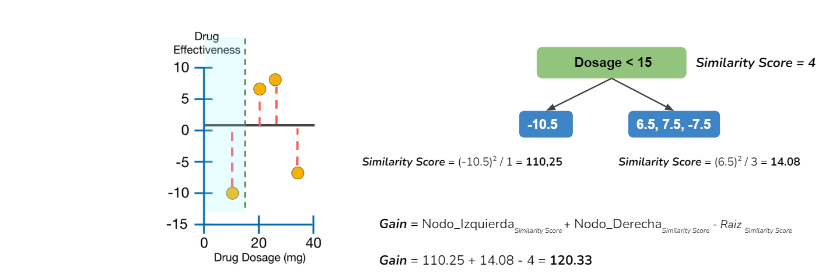

- Se hace lo mismo con todas las opciones y nos quedamos con el árbol que ofrezca la mayor ganancia. En este caso, nos quedamos con el primer árbol.

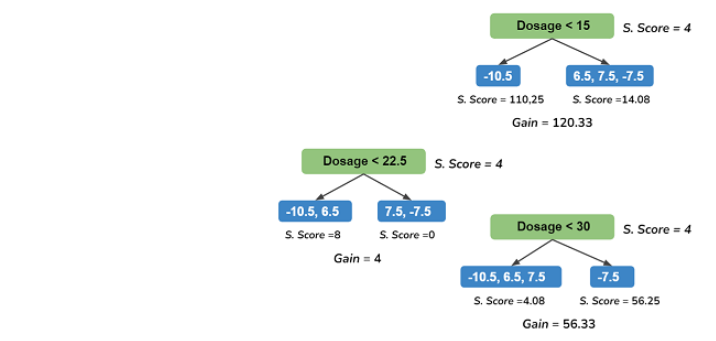

- Se repiten las particiones de los nodos hasta alcanzar la profundidad deseada (por defecto se trabajan con $6$ niveles de profundidad). Si bien el nodo de la izquierda no se puede dividir, sí se puede el de la derecha. A partir de esto, se obtienen dos árboles, donde el segundo presenta la mayor ganancia.

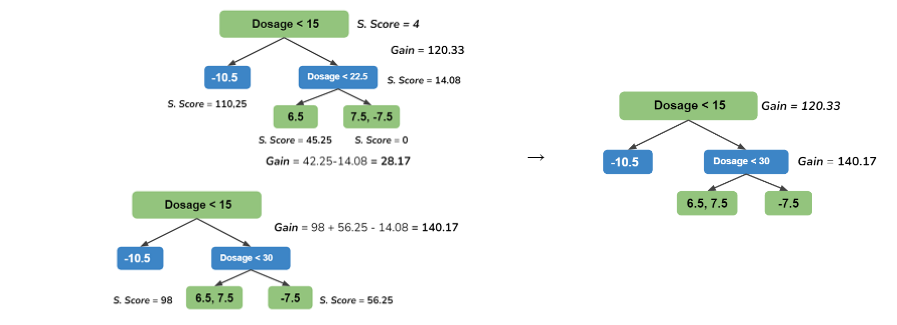

- Ahora, se poda el árbol resultante:
  - Se elige un número al azar, por ejemplo $130$. Se le llama $\gamma$.
  - Se calcula la diferencia entre la ganancia del nodo más bajo y $\gamma$.
  Queda $140.17 - 130 = 10.17$.
  - Si la diferencia es menor a $0$, se remueve el nodo. En este caso, permanece y se terminó la poda. \\
  Si se hubiera elegido un $\gamma = 150$, ahí sí se hubiera removido el nodo. En ese caso, se tendría que continuar la poda hacia arriba, y (con este ejemplo) se terminaría podando el árbol entero. Solo quedaría la estimación inicial de $0.5$.

- Se vuelve a calcular el árbol, pero con $\lambda = 1$.

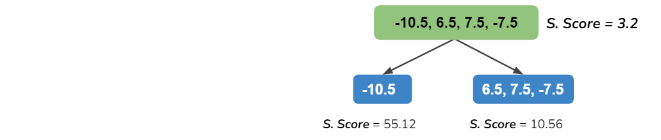

**Predecir un valor:**
- Se va a utilizar el arbol con $\lambda = 0$.
- Se calcula el output para cada nodo:
$$\textrm{output} = \frac{\textrm{suma de residuos}}{\textrm{n° de residuos} + \lambda}. $$.
- Para predecir se hace
$$\textrm{prediccion} = \textrm{estimacion_inicial} + \textrm{learning_rate} \times \textrm{valor_arbol}.$$
Por defecto $\textrm{learning_rate} = 0.3$.
- A partir de las predicciones, se repite todo el proceso con los nuevos residuos.


##### **Código**

In [ ]:
import xgboost as xgb

#Separo un set de Evaluacion
x_train, x_test, y_train, y_test = train_test_split(dataset[features].values,
                                                    dataset['Target'].values, 
                                                    test_size=0.2,                      #20% al conjunto de test
                                                    random_state=13,                    #para poder reproducir el experimento
                                                    stratify=dataset['Target'].values)  #estratificado para mantener proporcion
xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)
y_pred=xgb_model.predict(x_test)

## **Ensambles híbridos**

### **Voting**

Consiste en **construir $N$ modelos** utilizando los mismos datos y luego **tomar la predicción mayoritaria**.

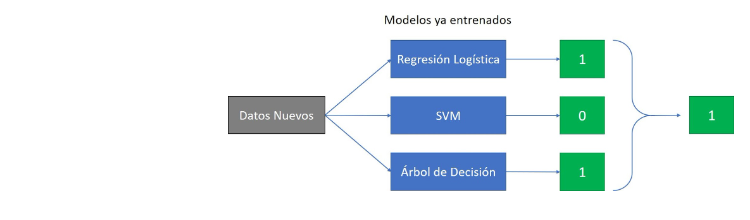

**Código.**

In [ ]:
from sklearn.ensemble import VotingClassifier

#Se crean los clasificadores (acá están vacíos)
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

#Se crea ensemble de Votación
vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

### **Stacking**

Consiste en **entrenar diferentes modelos** (modelos base) y **un modelo más**, **que decide**, dada una instancia nueva, **qué modelo usar**.


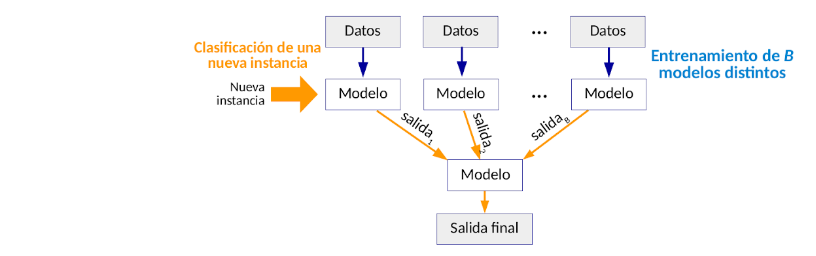

- Concepto de meta-aprendizaje para reemplazar el mecanismo de voto.
- Pueden apilarse tantas capas de modelos como se desee.
- Los modelos para el meta-aprendizaje suelen ser: árboles, NB, SVM o Perceptrón.
- Para los otros, puede usarse cualquier modelo.
- Es menos popular que boosting/bagging.
- Se puede interpretar como una mejora/generalización de la votación.
- Si los clasificadores base pueden generar medidas de certeza, suele funcionar mejor


**Código.**

In [ ]:
from sklearn.ensemble import StackingClassifier

#Modelos Base
base_models = [('random_forest', RandomForestClassifier(n_estimators=50)),
               ('svm', SVC()),
               ('knn', KNeighborsClassifier(n_neighbors=11))]

#Meta Modelo
meta_model = LogisticRegressionCV()

#Ensemble Stacking
stacking_model = StackingClassifier(estimators = base_models, 
                                    final_estimator = meta_model, 
                                    passthrough = True, 
                                    cv = 5,
                                    verbose = 2)

### **Cascading**

Enfoque en el que **se pasan sucesivamente los datos de un modelo a otro**.

- A diferencia de Stacking cada “capa” tiene un sólo modelo.
- El input de cada modelo son las instancias predichas con poca certeza por el modelo anterior.
- Suele utilizarse cuando se necesita una alta certeza en la predicción.

**Características**

- A diferencia de Voting y Stacking que tienen un enfoque de modelos “Multi-expertos”, Cascading tiene un enfoque “Multi-estado”.
- Inicialmente creados para computer vision.
- Cascadas muy profundas pueden producir overfitting


#### **Ejemplo**

Se quiere un modelo que prediga si una transacción con tarjeta de crédito es fraudulenta. Se necesita una alta certeza para definir si no lo es, en caso de error las pérdidas pueden ser millonarias.

Entonces, se entrenan $N$ modelos distintos utilizando nuestro set de entrenamiento.

Cada modelo se entrena sobre las instancias predichas con baja certeza del modelo anterior.

Suele hacerse de forma tal de empezar por modelos simples y a medida que se entrenan nuevos los mismos sean de mayor complejidad



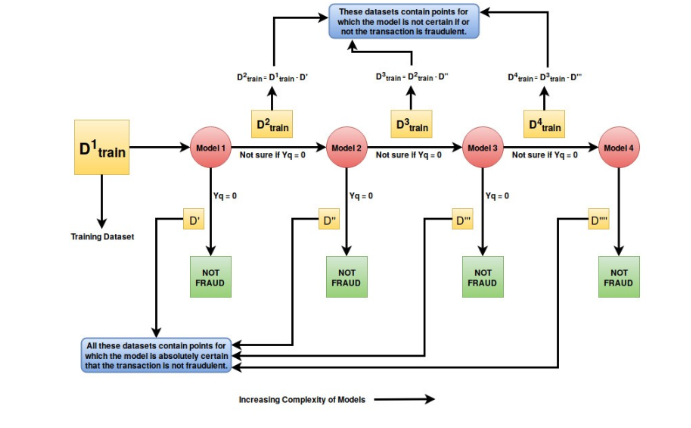

> **Pasos**
- El primer modelo recibe los datos de la transacción.
- Si la probabilidad de que no sea fraude es menor a $0.99$, se pasa al siguiente modelo. Caso contrario se descarta la posibilidad de fraude.
- Si ningún modelo descarta el fraude con $P < 0.99$ se procede a confirmar la operación de forma personal.


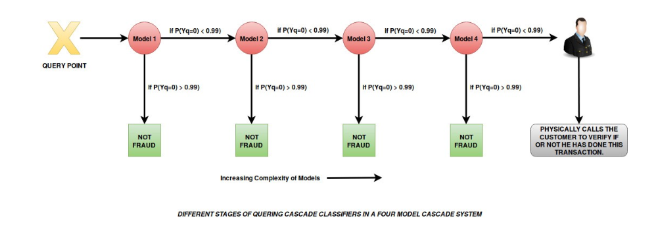